In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.metrics import mean_squared_error

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder

from category_encoders import OneHotEncoder

from sklearn.pipeline import make_pipeline
import sklearn
sklearn.set_config(display = 'diagram')
from sklearn.feature_selection import RFE

import folium
import matplotlib.lines as mlines

### Read in the data set:

In [2]:
df = pd.read_csv('./datasets/train.csv')

### Inspect Data:

In [3]:
pd.options.display.max_rows = None

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [4]:
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


### Data Cleaning:

In [5]:
# data description of 'MS SubClass' --> (Nominal): Identifies the type of dwelling involved in the sale.
# Showing in data set as an int, converting to object to use as classes

df_clean = df
df_clean['MS SubClass'] = df_clean['MS SubClass'].astype('object')

In [6]:
# 'Total Bsmt SF' and 'Garage Area' both have 1 NaN value each.
# Deleting both rows --> data set from 2051 to 2049

df_clean = df_clean[df_clean['Total Bsmt SF'].notna()]
df_clean = df_clean[df_clean['Garage Area'].notna()]
df_clean.shape

(2049, 81)

''

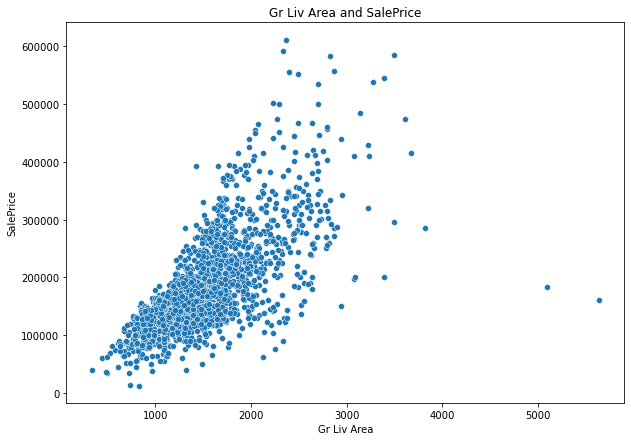

In [7]:
# from data dictionary:
# SPECIAL NOTES: There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). 
# Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). 
# I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

plt.figure(figsize = (10, 7))
sns.scatterplot(data = df_clean, x = 'Gr Liv Area', y ='SalePrice')
plt.title('Gr Liv Area and SalePrice')
plt.savefig('./images/sqft_price')
;

In [8]:
# Two outliers remain in the test data, remvoing to improve model as these will skew my results.

df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]
df_clean.shape

(2047, 81)

In [9]:
#checking average sale price by ms subclass

subclass = pd.DataFrame(df.groupby('MS SubClass')['SalePrice'].mean())
subclass.sort_values('SalePrice', inplace = True, ascending = False)
subclass.reset_index(inplace = True)
subclass

,MS SubClass,SalePrice
0,60,239225.769036
1,120,211813.613636
2,75,204875.000000
3,20,189305.488312
4,80,169569.825581
5,85,154398.214286
6,70,153354.455556
7,150,148400.000000
8,90,139296.333333
9,160,138452.215909


In [10]:
# change subclass names retrieved from data dictionary in order to have a readable bar chart

subclass['MS SubClass'] = subclass['MS SubClass'].map({
20: '1-STORY 1946 & NEWER ALL STYLES',
30: '1-STORY 1945 & OLDER',
40: '1-STORY W/FINISHED ATTIC ALL AGES',
45: '1-1/2 STORY - UNFINISHED ALL AGES',
50: '1-1/2 STORY FINISHED ALL AGES',
60: '2-STORY 1946 & NEWER',
70: '2-STORY 1945 & OLDER',
75: '2-1/2 STORY ALL AGES',
80: 'SPLIT OR MULTI-LEVEL',
85: 'SPLIT FOYER',
90: 'DUPLEX - ALL STYLES AND AGES',
120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
150: '1-1/2 STORY PUD - ALL AGES',
160: '2-STORY PUD - 1946 & NEWER',
180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'})

''

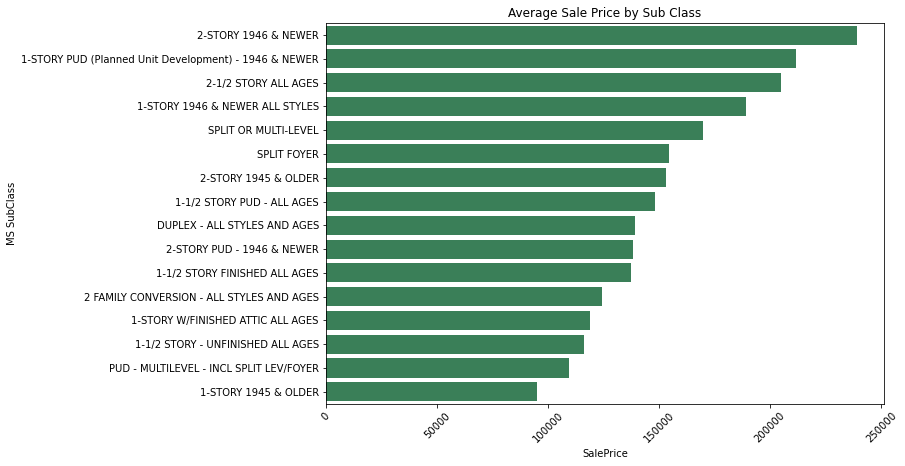

In [11]:
plt.figure(figsize = (10, 7))
sns.barplot(x = subclass['SalePrice'], y = subclass['MS SubClass'],  color = 'seagreen', orient = 'h')
plt.xticks(rotation=45)
plt.title('Average Sale Price by Sub Class')
plt.savefig('./images/mssubclass', bbox_inches='tight')
;

In [12]:
#checking average sale price by neighborhood

neighborhood = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].mean())
neighborhood.sort_values('SalePrice')

,SalePrice
Neighborhood,
MeadowV,100231.250000
IDOTRR,101103.188406
BrDale,103371.052632
OldTown,125276.300613
BrkSide,127022.697368
Edwards,130493.468531
SWISU,134758.875000
Landmrk,137000.000000
Sawyer,137181.909910


### Create X and y:

In [13]:
X = df_clean[['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area', 'Neighborhood', 'MS SubClass']]
y = df_clean['SalePrice']

In [22]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2050
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gr Liv Area    2047 non-null   int64  
 1   Overall Qual   2047 non-null   int64  
 2   Total Bsmt SF  2047 non-null   float64
 3   Garage Area    2047 non-null   float64
 4   SalePrice      2047 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 96.0 KB


''

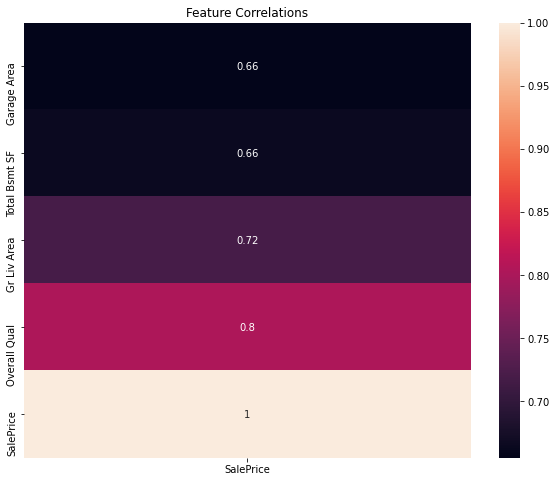

In [14]:
# Heatmap of correlation between selected columns and Sale Price (numerical columns only)

numerical_df = df_clean[['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area', 'SalePrice']]


plt.figure(figsize=(10,8))
sns.heatmap(numerical_df.corr()[['SalePrice']].sort_values(by='SalePrice'), annot=True)
plt.title('Feature Correlations')
plt.savefig('./images/correlations')

;

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 45)

##### Conclusion:

The four numerical columns all have a p-value of 0, suggesting the coefficients are significant.<br>

1) Gr Liv Area (Continuous): Above grade (ground) living area square feet<br>
2) Overall Qual (Ordinal): Rates the overall material and finish of the house<br>
3) Total Bsmt SF (Continuous): Total square feet of basement area<br>
4) Garage Area (Continuous): Size of garage in square feet<br>

The two object columns vary on significance. <br>

1) Neighborhood (Nominal): Physical locations within Ames city limits (map available)<br>
2) MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.

### Make Pipeline

In [16]:
# Pipeline will include scaling and linear regression.

pipe = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), ElasticNet())
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

### Fitting pipeline to total data set

In [17]:
# Fit pipeline to total data set in order to create best model using all of the information I have.

pipe.fit(X, y)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood', 'MS SubClass'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

In [18]:
np.mean(cross_val_score(pipe, X, y))

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\categor

0.8353897025002646

In [19]:
# R-squared score on total data

pipe.score(X, y)

0.8393769583179924

In [20]:
# Gr Liv Area and Overall Qual hae the highest coefficients

pipe.named_steps['elasticnet'].coef_

array([17561.37945963, 17757.29218716, 14014.13129113, 10821.50694744,
       -2052.19604717,  -762.38805203, -4070.67845109,  1942.14577469,
       -2102.13363992, -4243.43101714, -1137.59585032,  -208.27589657,
        2360.8899121 , -1010.12366492,  7001.11870455,  9872.13114342,
        -552.15274495,  2808.38132745, -2616.4315199 , -1889.00325738,
        1537.28642285,  -914.81033129, -1433.07497023,  4463.1519834 ,
        1498.28875779,   209.59758112, -1269.45293064, -1042.38843286,
        -474.17605555,  2416.31678045,  -166.85898823,  -130.54488643,
        4915.24688911,  2089.26453999, -2588.43236701,    82.14542095,
       -2825.36180625, -1250.91100074, -1419.32224153, -1560.07153544,
         582.5255401 , -1942.58559818, -2616.84969222,   527.18812881,
         201.04104643,  -383.93865611,  -384.59484442,  -625.69992631])

In [21]:
pipe.named_steps['elasticnet'].

SyntaxError: invalid syntax (<ipython-input-21-d2e6dfe4d6cb>, line 1)

In [ ]:
# RMSE score on total data

preds = pipe.predict(X)
mean_squared_error(preds, y, squared = False)

In [ ]:
predictions = pd.DataFrame(y)

In [ ]:
predictions['preds'] = preds

In [ ]:
predictions.rename(columns={'SalePrice': 'Actual Sale Price', 'preds': 'Predicted Sale Price'}, inplace = True)

In [ ]:
predictions.head()

In [ ]:
# https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot

plt.figure(figsize = (10, 8))
sns.regplot(data = predictions, x = 'Actual Sale Price', y = 'Predicted Sale Price', line_kws={'color': 'black'})
plt.title('Actual vs. Predicted Sale Prices')
plt.ylim(0, 600000)

plt.savefig('./images/final_preds')
;

In [ ]:
df[df['SalePrice'] > 300000].shape[0] / df.shape[0]

In [ ]:
residuals = y - preds
stats.probplot(residuals, plot = plt);

The R-squared score is still consistent and the RMSE is in line with the train and test data.

In [ ]:
neighborhood.head()

In [ ]:
# locations pulled from ames website and google maps of areas
# https://www.cityofames.org/home/showpublisheddocument/1024/637356764775500000

# Somerst: 42.05066674474766, -93.6431158154304
# CollgCr: 42.01935229693197, -93.68042276984161
# NridgHt: 42.06110357352848, -93.65343685221326
# Mitchel: 41.99529157024668, -93.60279568424768
# Sawyer: 42.032822998157, -93.6733913730291
# StoneBr: 42.05979050390679, -93.63869352778428
# OldTown: 42.02924123015253, -93.61440447518692

In [ ]:
# creating a map of selected areas and average sale prices

m = folium.Map(location = [42.02924123015253, -93.61440447518692], zoom_start = 13)


folium.Circle([42.05066674474766, -93.6431158154304], 227, fill=True).add_child(folium.Popup('Somerst: $227k', show = True)).add_to(m)
folium.Circle([42.01935229693197, -93.68042276984161], 202, fill=True).add_child(folium.Popup('CollgCr: $202k', show = True)).add_to(m)
folium.Circle([42.06110357352848, -93.65343685221326], 323, fill=True).add_child(folium.Popup('NridgHt: $323k', show = True)).add_to(m)
folium.Circle([41.99529157024668, -93.60279568424768], 168, fill=True).add_child(folium.Popup('Mitchel: $168k', show = True)).add_to(m)
folium.Circle([42.032822998157, -93.6733913730291], 137, fill=True).add_child(folium.Popup('Sawyer: $137k', show = True)).add_to(m)
folium.Circle([42.05979050390679, -93.63869352778428], 329, fill=True).add_child(folium.Popup('StoneBr: $329k', show = True)).add_to(m)
folium.Circle([42.02924123015253, -93.61440447518692], 125, fill=True).add_child(folium.Popup('OldTown: $125k', show = True)).add_to(m)
m.save('./images/ames_map.html')
m


